OI pacakge is installed in tianyi 3.11 kernel rather than base 3.11, where base 3.11 installed the nomic stuff. 

In [1]:
import h5py
import numpy as np
import pandas as pd
import pickle as pkl
import os
import sys
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
from pprint import pprint

In [2]:
import networkx as nx
import numpy as np
import time
import sys
from oitools import ecr
import matplotlib.pyplot as plt
plt.ion()

In [4]:
import os
os.getcwd()

'/cis/home/tchen94/tianyi/Organoid/Raw_data_processing'

In [5]:
ls /cis/project/organoid/

'2024May28 No window data '/           Dec_29_2024_ecr_results/
 3_org_stim_vs_1_organoid/            'March 30 2024'/
'April 19 2024'/                       May_31_2025/
 Aug_25_2025_Mo7357/                   May_31_2025_ecr_results_no_window/
 Dec_10_2024/                          Nov_18_2024/
 Dec_10_2024_ecr_results_no_window/    Nov_18_2024_ecr_results3_no_window/
 Dec_10_2024_ecr_results_tuning_exp/   Nov_18_2024_ecr_results_for_tuning/


In [37]:
find /cis/home/tchen94/tianyi/ -name connectivity.py

SyntaxError: invalid syntax (2827765867.py, line 1)

In [29]:
sys.path.append('../../utils')  # Example for two levels upfrom connectivity import EffectiveConnectivityRecon

In [32]:
from connectivity import EffectiveConnectivityRecon

ModuleNotFoundError: No module named 'connectivity'

In [17]:
import os

# Define the relative path to the utils directory
utils_path = os.path.join(os.getcwd(), '../utils')

# Check if connectivity.py exists
connectivity_file = os.path.join(utils_path, 'connectivity.py')

if os.path.exists(connectivity_file):
    print(f"'connectivity.py' exists at: {connectivity_file}")
else:
    print(f"'connectivity.py' does NOT exist in {utils_path}")

'connectivity.py' does NOT exist in /cis/home/tchen94/tianyi/Organoid/../utils


Creating random graph with seed 0.

Creating random spikes with seed 0... took 2.49 seconds.

Using maximum of 15 CPUs for processing.


Accuracy metric scores are 0.133, 0.000, and 0.869.
0.8686252379027267
0.0


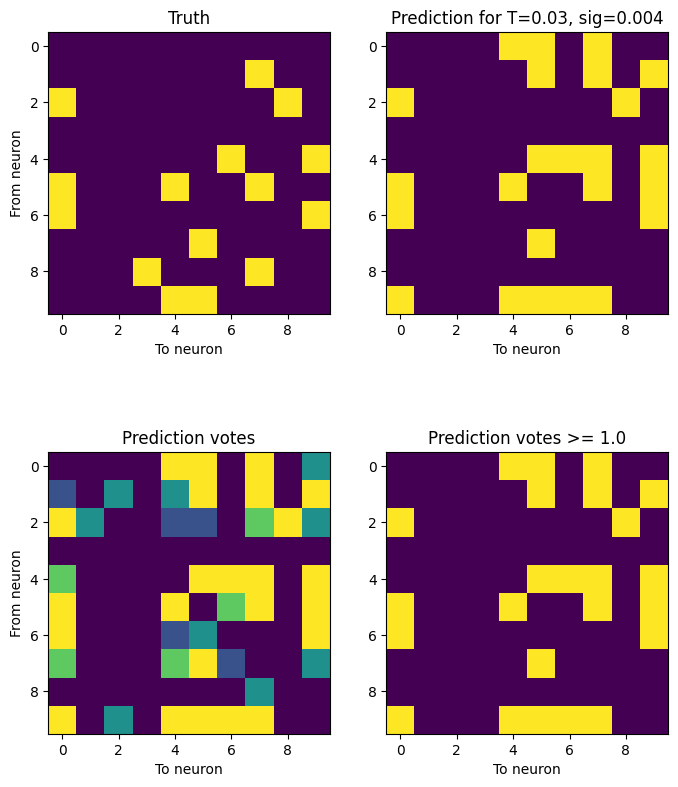

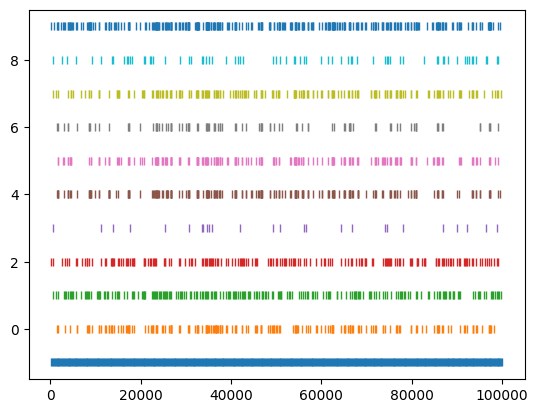

In [18]:
rng_seed_graph = 0     # A scalar
rng_seed_spikes = [0]  # An iterable


n_neurons = 10
n_inputs_max = 4        # Each neurons gets between 1 and n_inputs_max input from other neurons or the stimulus
p_spike = 0.4           # Probability that a post synaptic neurons fires after a presynaptic neuron fires
t_res = 0.001           # Spike timing resolution
dur_post_mean = 0.010   # Mean delay from pre to post firing, "a rough indication of the delay in synaptically connected cortical neurons was estimated to be 6–14 ms (Gonzalez-Burgos, 2000)"
dur_post_delta = 0.004  # Delay is random, within [dur_post_mean-dur_post_delta, dur_post_mean+dur_post_delta]
f_stim_rate = 5         # Mean stimulus spike rate (per second)
dur_stim = 100           # Stimulus duration, in seconds


# eps = 0.03
# T_list = [0.15, 0.22]
# sigma_list = [0.003, 0.008]
# adj_threshold = 0.5
# time_resolution = 0.001

eps = 0.015
# T_list = np.array([1, 2, 3]) * dur_post_mean
# sigma_list = np.array([0.5, 1, 2]) * dur_post_delta

T_list = np.array([2, 3]) * dur_post_mean
sigma_list = np.array([0.5, 1]) * dur_post_delta

# T_list = np.array([3]) * dur_post_mean
# sigma_list = np.array([0.5]) * dur_post_delta

amp_thresh_percentile = 50
adj_threshold = 1.0
time_resolution = 0.001


rng_graph = np.random.default_rng(rng_seed_graph)
rng_spikes = np.random.default_rng(rng_seed_spikes)

if True:
    # Create network nodes
    print(f'Creating random graph with seed {rng_seed_graph}.')
    graph = nx.DiGraph()
    graph.add_node(0, type='stimulus')
    for i_node in range(1, n_neurons+1):
        graph.add_node(i_node, type='neuron')

    # Create network edges
    for ix_postsyn in range(1, n_neurons+1):
        n_inputs = rng_graph.choice(np.arange(1, n_inputs_max))
        ix_pre_possible = np.arange(n_neurons+1)
        ix_pre_possible = np.delete(ix_pre_possible, ix_postsyn)  # Don't let a neuron connect to itself
        ix_presyns = rng_graph.choice(ix_pre_possible, size=n_inputs)
        for ix_presyn in ix_presyns:
            graph.add_edge(ix_presyn, ix_postsyn)
else:
    # Create the three-neuron example of Puppo et al.
    n_neurons = 3
    graph = nx.DiGraph()
    graph.add_node(0, type='stimulus')
    for i_node in range(1, n_neurons+1):
        graph.add_node(i_node, type='neuron')
    graph.add_edge(0, 3)  # Apply external stimulation to neuron 3
    graph.add_edge(3, 2)
    graph.add_edge(1, 2)
    graph.add_edge(2, 1)

# Visualize the graph
if False:
    draw_options = {
        'node_size': 100,
        'width': 1,
    }
    # nx.draw(graph, **draw_options)
    node_colors = []
    for node in graph:
        match graph.nodes[node]['type']:
            case 'stimulus':
                node_colors.append('green')
            case 'neuron':
                node_colors.append('blue')
    plt.figure(1)
    node_pos = nx.spring_layout(graph, seed=0)
    nx.draw(graph, pos=node_pos, node_color=node_colors, **draw_options)
    # nx.draw(graph, node_color=node_colors, **draw_options)

# Create the true adjacency matrix
adj_matrix_true = np.full((n_neurons, n_neurons), False)
for rx_node in range(1, n_neurons+1):
    for edge in graph.in_edges(rx_node):
        if edge[0] >= 1:
            adj_matrix_true[edge[0]-1, rx_node-1] = True


history_acc3 = []
print('')
for rng_seed in rng_seed_spikes:
    t = time.time()
    print(f'Creating random spikes with seed {rng_seed}... ', end='')
    rng_spikes = np.random.default_rng(rng_seed)

    # Create stimulus "spikes", using Poisson distributions
    lam = (1/f_stim_rate)/t_res  # mean time between spikes, in units of t_res
    dt_stim_spikes = rng_spikes.poisson(lam=lam, size=f_stim_rate*dur_stim) * t_res
    t_stim_spikes = np.cumsum(dt_stim_spikes)
    t_stim_spikes = t_stim_spikes[t_stim_spikes < dur_stim]

    # Induce spikes amongst neurons
    n_samp_post_mean = int(dur_post_mean/t_res)
    n_samp_post_delta = int(dur_post_delta/t_res)
    n_samples = int(dur_stim/t_res)
    sample_num_stim_spikes = (t_stim_spikes / t_res).astype(int)
    # sample_num_spikes = [sample_num_stim_spikes] + [[] for _ in range(n_neurons)]

    stim_sig = np.full(n_samples, False)
    stim_sig[sample_num_stim_spikes] = True
    all_sigs = [stim_sig] + [np.full(n_samples, False) for _ in range(n_neurons)]

    rng_spikes = np.random.default_rng(rng_seed)  # Reset seed after creation of stimulus spikes, so we get same results across time even for different durations
    for sample in range(n_samples):
        for node in range(1, n_neurons+1):
            for in_edge in graph.in_edges(node):
                in_node = in_edge[0]
                # if sample in sample_num_spikes[in_node]:
                if all_sigs[in_node][sample]:
                    if rng_spikes.choice((True, False), p=[p_spike, 1-p_spike]):
                        # Add a spike to this neuron
                        sample_num_spike = sample + n_samp_post_mean + rng_spikes.integers(-n_samp_post_delta, n_samp_post_delta+1)
                        # sample_num_spikes[node].append(sample_num_spike)
                        if sample_num_spike < n_samples:
                            all_sigs[node][sample_num_spike] = True
    sample_num_spikes = [np.argwhere(sig)[:, 0] for sig in all_sigs]
    
    # Convert all spike times from sample numbers into seconds
    t_neuron_spikes = [[sn*t_res for sn in samp_nums] for samp_nums in sample_num_spikes[1:]]
    print(f'took {(time.time()-t):0.2f} seconds.')

    # Estimate the connectivity
    # ecr = EffectiveConnectivityRecon(epsilon=eps, T_list=T_list, sigma_list=sigma_list, adj_threshold=adj_threshold,
    ss_ecr = ecr.SuperSelective(epsilon=eps, T_list=T_list, sigma_list=sigma_list, adj_threshold=adj_threshold,
                                amp_thresh_percentile=amp_thresh_percentile, time_resolution=t_res)
    adj_matrix_predicted, votes, corr_peaks = ss_ecr(t_neuron_spikes)

    # Computed "accuracy" of voted prediction
    N = np.sum(adj_matrix_true )  # Number of actual connections
    TP = np.sum( adj_matrix_true &  adj_matrix_predicted)
    TN = np.sum(~adj_matrix_true & ~adj_matrix_predicted)
    FP = np.sum(~adj_matrix_true &  adj_matrix_predicted)
    FN = np.sum( adj_matrix_true & ~adj_matrix_predicted)

    acc1_final = (TP - FP)/N
    acc2_final = (TP - FP - FN)/N

    acc_conn = TP / np.sum(adj_matrix_true)
    acc_no_conn = TN / np.sum(~adj_matrix_true)
    acc3_final = (acc_conn * acc_no_conn)**0.5

    print(f'\nAccuracy metric scores are {acc1_final:0.3f}, {acc2_final:0.3f}, and {acc3_final:0.3f}.')
    history_acc3.append(acc3_final)


print(np.mean(history_acc3))
print(np.std(history_acc3))


plt.figure('Connectivity Matrices', figsize=(8, 10))
plt.subplot(2, 2, 1)
plt.imshow(adj_matrix_true)
plt.title('Truth')
plt.xlabel('To neuron')
plt.ylabel('From neuron')
# plt.imshow(np.logical_or(adj_matrix_true, adj_matrix_true.T))

plt.subplot(2, 2, 2)
plt.imshow(adj_matrix_predicted)
plt.title(f'Prediction for T={T_list[-1]}, sig={sigma_list[-1]}')
plt.xlabel('To neuron')
# plt.ylabel('From neuron')

plt.subplot(2, 2, 3)
plt.imshow(votes)
plt.title('Prediction votes')
plt.xlabel('To neuron')
plt.ylabel('From neuron')

plt.subplot(2, 2, 4)
plt.imshow(votes >= adj_threshold)
plt.title(f'Prediction votes >= {adj_threshold}')
plt.xlabel('To neuron')
# plt.ylabel('From neuron')


plt.figure('Spikes')
t_neuron_spikes = [(t/t_res).astype(int) for t in t_neuron_spikes]
plt.plot(sample_num_stim_spikes, np.full(len(sample_num_stim_spikes), -1), '|')
for i_neuron, t_spikes in enumerate(t_neuron_spikes):
    plt.plot(t_spikes, np.full(len(t_spikes), i_neuron), '|')

In [19]:
from oitools import ecr

In [20]:

# Path of source .h5 files
path_source_files = '/cis/project/organoid/Nov_18_2024/'

# Path where results will be stored
path_results = '/cis/project/organoid/Nov_18_2024/mea_results'

In [21]:

# Get a list of files that we'll analyze

# Get list of all h5 files in the target directory
filenames = os.listdir(path_source_files)
filenames = [fn for fn in filenames if fn.endswith('.h5')]

# Get list of file sizes
sizes = []
for f in filenames:
    sizes.append(os.stat(os.path.join(path_source_files, f)).st_size)

# Excluding files that are relatively small
thresh = np.median(sizes)/4
print(f'Exluding files of size less than {thresh/1e6:0.3f} MB.')
filenames = [fn for fn, sz in zip(filenames, sizes) if sz>=thresh]

print(f'\nAssessing these h5 files in {path_source_files}.')
pprint(filenames)

Exluding files of size less than 2764.922 MB.

Assessing these h5 files in /cis/project/organoid/Nov_18_2024/.
['data.raw.h5']


In [24]:

# Print out well names for each file

for filename in filenames:
    fullname = os.path.join(path_source_files, filename)
    ephys_file = h5py.File(fullname, 'r')
    
    print(f'\n{filename}:\n\t', end='')
    print(list(ephys_file['recordings']['rec0000'].keys()))


data.raw.h5:
	['well000', 'well001', 'well002', 'well003', 'well004', 'well005']


In [28]:

fs = 10000  # Sampling rate for all Maxwell spike data

## Values used to filter out invidual spikes, and channel with low spike count
thresh_spike_amp_percentile = 5  # Discard the low P percentile of spikes, which may just be noise
thresh_spikes_per_chan_std = 2  # Discard channels with < mean(n_spikes)+spike_cnt_thresh_std*std(n_spikes), on log scale

## Values used for Puppa's ECR algorithm
amp_thresh_percentile = None
amp_thresh_std = 1
adj_threshold = 1.0
time_resolution = 1/fs
# Values used in Puppa paper, on real spike data...
raster_dur = 0.0005
corr_type = 'cc'  ## 'cc'==cross-correlation, 'pearson' not yet implemented
epsilon = 0.003
T_list = np.array([0.020, 0.0175, 0.016])
sigma_list = np.array([0.0004, 0.00055, 0.0007])

parameters = {}
parameters['epsilon'] = epsilon
parameters['T_list'] = T_list
parameters['sigma_list'] = sigma_list
parameters['amp_thresh_percentile'] = amp_thresh_percentile
parameters['amp_thresh_std'] = amp_thresh_std
parameters['raster_dur'] = raster_dur
parameters['corr_type'] = corr_type
parameters['adj_threshold'] = adj_threshold
parameters['time_resolution'] = time_resolution

ecr = EffectiveConnectivityRecon(epsilon=epsilon,
                                 T_list=T_list,
                                 sigma_list=sigma_list,
                                 amp_thresh_percentile=amp_thresh_percentile,
                                 amp_thresh_std=amp_thresh_std,
                                 raster_dur=raster_dur,
                                 corr_type=corr_type,
                                 adj_threshold=adj_threshold,
                                 time_resolution=time_resolution,
                                 use_multiprocessing=True,
                                 verbose=False)

os.makedirs(path_results, exist_ok=True)


NameError: name 'EffectiveConnectivityRecon' is not defined